# COSC 498: Capstone Project
**Amanda White**

Problem: Predicting stock prices is a complex challenge due to market fluctuations, economic factors, and investor behavior. Many traders, investors, and financial analysts struggle to make informed decisions because they lack accurate predictive tools.
Current methods rely on historical trends, news sentiment, and expert opinions, but these can be subjective and inconsistent. My project leverages machine learning to provide data-driven stock price forecasts, helping users make smarter investment decisions based on historical patterns and technical indicators.

In [2]:
# Step 1: Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [3]:
# Download stock data for Apple (AAPL) from the past 5 years
ticker = "AAPL"
data = yf.download(ticker, start="2019-01-01", end="2024-01-01")

# Save data as CSV
data.to_csv("AAPL_stock_data.csv")

# Display the first few rows
print(data.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2019-01-02  37.667187  37.889013  36.787045  36.944469  148158800
2019-01-03  33.915257  34.757234  33.869937  34.342207  365248800
2019-01-04  35.363064  35.432237  34.299264  34.473383  234428400
2019-01-07  35.284359  35.499030  34.800162  35.468021  219111200
2019-01-08  35.956993  36.212212  35.425093  35.673153  164101200


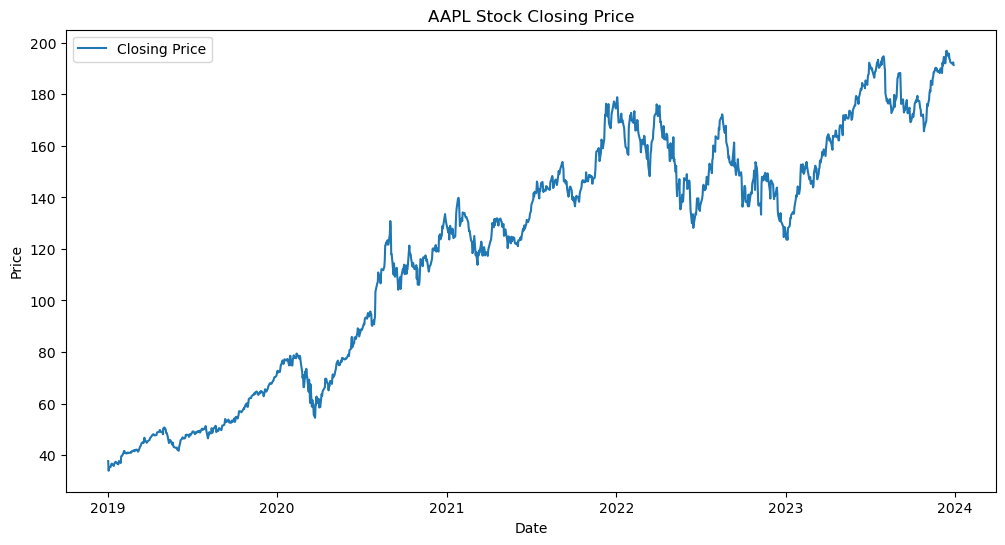

In [4]:
# Historical Trends for past 5 years

# Plot stock closing price
plt.figure(figsize=(12,6))
plt.plot(data["Close"], label="Closing Price")
plt.title(f"{ticker} Stock Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


In [5]:
# Check for missing data
print(data.isnull().sum())

# If there is missing data forward fill.
data.ffill(inplace=True)

Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64


In [6]:
# Add Moving Averages (e.g., 50-day and 200-day):
data['MA50'] = data['Close'].rolling(window=50).mean()
data['MA200'] = data['Close'].rolling(window=200).mean()


In [7]:
# Add Relative Strength Index (RSI):
def calculate_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI'] = calculate_rsi(data)

In [8]:
# Add previous days' closing prices:
data['Lag_1'] = data['Close'].shift(1)
data['Lag_2'] = data['Close'].shift(2)

In [9]:
# Split 80-20
X = data[['Close', 'MA50', 'MA200', 'RSI', 'Lag_1', 'Lag_2']].dropna()
y = X.pop('Close')  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# Normalize features using Min-Max scaling:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [11]:
# Train a Linear Regression Model:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = lr.predict(X_test_scaled)

# Evaluate performance
print("Linear Regression:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE", mean_absolute_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))


Linear Regression:
MSE: 4.80282843791092
MAE 1.580467640779776
R^2: 0.9964587337102899


In [12]:
# Test random forest:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

print("Random Forest:")
print("MSE:", mean_squared_error(y_test, y_pred_rf))
print("MAE", mean_absolute_error(y_test, y_pred_rf))
print("R^2:", r2_score(y_test, y_pred_rf))


C:\Users\amand\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest:
MSE: 4.9957802008655925
MAE 1.6299139119993966
R^2: 0.9963164647155663


In [13]:
# Prepare Data for LSTM:
X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))


In [14]:
# Build the LSTM Architecture:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')


In [15]:
# Train the Model:
model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, validation_data=(X_test_lstm, y_test))


Epoch 1/20
27/27 [==============================] - 6s 47ms/step - loss: 19444.7598 - val_loss: 18637.0605
Epoch 2/20
27/27 [==============================] - 0s 8ms/step - loss: 17863.8848 - val_loss: 16449.3594
Epoch 3/20
27/27 [==============================] - 0s 10ms/step - loss: 16539.2773 - val_loss: 15880.9141
Epoch 4/20
27/27 [==============================] - 0s 10ms/step - loss: 16043.9648 - val_loss: 15455.0215
Epoch 5/20
27/27 [==============================] - 0s 9ms/step - loss: 15642.4961 - val_loss: 15069.7061
Epoch 6/20
27/27 [==============================] - 0s 10ms/step - loss: 15253.3711 - val_loss: 14707.1650
Epoch 7/20
27/27 [==============================] - 0s 10ms/step - loss: 14904.2266 - val_loss: 14362.3281
Epoch 8/20
27/27 [==============================] - 0s 10ms/step - loss: 14548.3789 - val_loss: 14031.1367
Epoch 9/20
27/27 [==============================] - 0s 10ms/step - loss: 14209.6650 - val_loss: 13708.0283
Epoch 10/20
27/27 [====================

In [16]:
# Evaluate the Model:
y_pred_lstm = model.predict(X_test_lstm)
print("LSTM Model:")
print("MSE:", mean_squared_error(y_test, y_pred_lstm))
print("MAE", mean_absolute_error(y_test, y_pred_lstm))
print("R^2:", r2_score(y_test, y_pred_lstm))

7/7 [==============================] - 1s 3ms/step
LSTM Model:
MSE: 10666.938022170458
MAE 96.49888551460123
R^2: -6.865046299419573


In [17]:
# Hyperparameter Tuning for Random Forest
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None]}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator

C:\Users\amand\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\amand\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\amand\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\amand\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator'

In [ ]:
# Evaluate Best Random Forest
best_rf_preds = best_rf_model.predict(X_test)
print("Best Random Forest:")
print("MSE:", mean_squared_error(y_test, best_rf_preds))
print("MAE:", mean_absolute_error(y_test, best_rf_preds))
print("R^2:", r2_score(y_test, best_rf_preds))

In [ ]:
# Test all models on unseen data and summarize results
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Best Random Forest', 'LSTM'],
    'MSE': [
        mean_squared_error(y_test, lr_preds),
        mean_squared_error(y_test, rf_preds),
        mean_squared_error(y_test, best_rf_preds),
        mean_squared_error(y_test, lstm_preds)
    ],
    'MAE': [
        mean_absolute_error(y_test, lr_preds),
        mean_absolute_error(y_test, rf_preds),
        mean_absolute_error(y_test, best_rf_preds),
        mean_absolute_error(y_test, lstm_preds)
    ],
    'R^2': [
        r2_score(y_test, lr_preds),
        r2_score(y_test, rf_preds),
        r2_score(y_test, best_rf_preds),
        r2_score(y_test, lstm_preds)
    ]
})

print(results)

In [ ]:
# Plot predictions from the best model
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual')
plt.plot(scaler.inverse_transform(best_rf_preds.reshape(-1, 1)), label='Predicted')
plt.title('Stock Price Prediction - Best Model')
plt.legend()
plt.show()

This is currently the end of the backend code. Week 5 plans to add the UI and week 6 plans to pull additional stock data. I plan to try to pull Bitcoin and XRP along with Facebook and amazon.